In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits import mplot3d
import seaborn as sns
import h5py

from keras.models import Sequential
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras.optimizers import adam, adadelta
from keras.models import Model
from keras.utils.np_utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
with h5py.File('data/full_dataset_vectors.h5') as hf:
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]    
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:] 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10000, 4096), (10000,), (2000, 4096), (2000,))

(19000, 3)


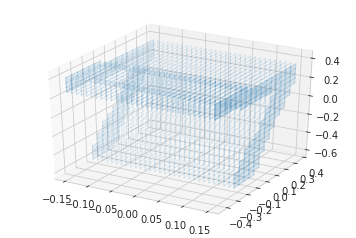

In [57]:
# plot sample point cloud
with h5py.File('data/test_point_clouds.h5', 'r') as hf:
    p = hf['0']['points'][:]
    print(p.shape)
    ax = plt.axes(projection='3d')
    ax.scatter(p[:,0], p[:,1], p[:,2], s=0.01)
    plt.show()

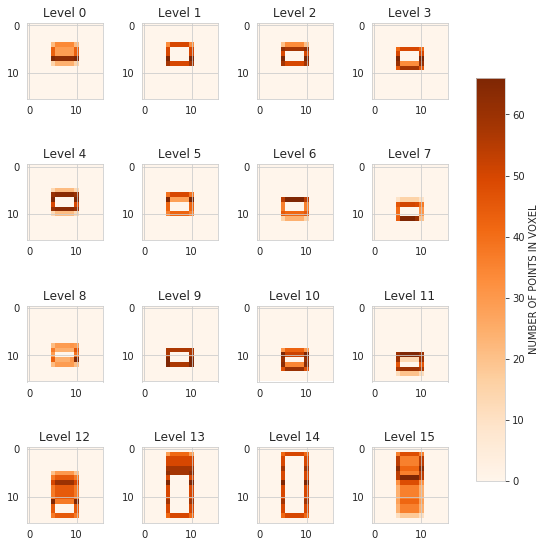

In [62]:
from voxelgrid import VoxelGrid
voxel_grid = VoxelGrid(p, x_y_z = [16, 16, 16])
voxel_grid.plot()

In [4]:
# translate data to color
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

# iterate dataset, add rgb dimension
def add_rgb_to_data(data):
    # introduce channel dimension to dataset
    data_w_rgb = np.ndarray((data.shape[0], data.shape[1], 3))
    for i in range(data.shape[0]):
        data_w_rgb[i] = add_rgb_dimention(data[i])
    return data_w_rgb

In [5]:
X_train_rgb = add_rgb_to_data(X_train)
X_test_rgb = add_rgb_to_data(X_test)

# convert to 1 + 4D space
X_train_rgb = X_train_rgb.reshape(-1,16,16,16,3)
X_test_rgb = X_test_rgb.reshape(-1,16,16,16,3)
X_train_rgb.shape, X_test_rgb.shape

((10000, 16, 16, 16, 3), (2000, 16, 16, 16, 3))

In [6]:
y_train_ohe = to_categorical(y_train, 10)
y_test_ohe = to_categorical(y_test, 10)
y_train_ohe.shape, y_test_ohe.shape

((10000, 10), (2000, 10))

In [3]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)
print("Accuracy: ", reg.score(X_test, y_test))

Accuracy:  0.57


In [69]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Accuracy: ", rf.score(X_test, y_test))

Accuracy:  0.6625


In [12]:
def Conv(filters=16, kernel_size=(3,3,3), activation='relu', input_shape=None):
    if input_shape:
        return Conv3D(filters=filters, kernel_size=kernel_size, padding='Same', activation=activation, input_shape=input_shape)
    else:
        return Conv3D(filters=filters, kernel_size=kernel_size, padding='Same', activation=activation)

def create_model(input_dim, num_classes):
    model = Sequential()
    model.add(Conv(8, input_shape=input_dim))
    model.add(Conv(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool3D())

    model.add(Conv(32))
    model.add(Conv(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool3D())
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    return model

In [13]:
model = create_model((16,16,16,3), 10)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 16, 16, 16, 8)     656       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 16, 16, 16, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 16, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 8, 8, 16)       0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 8, 8, 32)       13856     
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 8, 8, 64)       55360     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 8, 64)       256       
__________

In [14]:
# model callbacks

patience_earlystop = 7
patience_ReduceLROnPlateau = 3

filepath = 'best_weight.h5'
mcp = ModelCheckpoint(filepath, monitor='val_loss',
                      mode='min', save_best_only=True,
                      save_weights_only=True, verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=patience_earlystop,
                          verbose=1)

lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=patience_ReduceLROnPlateau, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=1e-5)

In [15]:
batch_size = 64
epochs = 50
history = model.fit(x=X_train_rgb,
                    y=y_train_ohe,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[mcp, earlystop, lr_reduction])

Train on 8500 samples, validate on 1500 samples
Epoch 1/50
8500/8500 [==============================] - 149s 18ms/step - loss: 5.2082 - acc: 0.2906 - val_loss: 9.7458 - val_acc: 0.0973

Epoch 00001: val_loss improved from inf to 9.74576, saving model to best_weight.h5
Epoch 2/50
8500/8500 [==============================] - 146s 17ms/step - loss: 1.4952 - acc: 0.4796 - val_loss: 5.6094 - val_acc: 0.1987

Epoch 00002: val_loss improved from 9.74576 to 5.60945, saving model to best_weight.h5
Epoch 3/50
8500/8500 [==============================] - 148s 17ms/step - loss: 1.3099 - acc: 0.5462 - val_loss: 1.5673 - val_acc: 0.4527

Epoch 00003: val_loss improved from 5.60945 to 1.56732, saving model to best_weight.h5
Epoch 4/50
8500/8500 [==============================] - 148s 17ms/step - loss: 1.1922 - acc: 0.5809 - val_loss: 1.3892 - val_acc: 0.5073

Epoch 00004: val_loss improved from 1.56732 to 1.38919, saving model to best_weight.h5
Epoch 5/50
8500/8500 [==============================] - 

In [16]:
#Define a smooth function to display the training and validation curves
def plot_smoothed_learning_curves(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(acc)+1 )
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    ax[0].plot(epochs, smooth_curve(loss), 'tab:blue', label='Smoothed training loss')
    ax[0].plot(epochs, smooth_curve(val_loss), 'tab:orange', label='Smoothed validation loss')
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    
    ax[1].plot(epochs, smooth_curve(acc), 'tab:blue', label='Smoothed training accuracy')
    ax[1].plot(epochs, smooth_curve(val_acc), 'tab:orange', label='Smoothed validation accuracy')
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')

def smooth_curve(points, factor=0.8):
    smoothed_points = [points[0]]
    for i in range(1, len(points)):
        smoothed_points.append(points[i - 1] * factor + points[i] * (1 - factor))
    return smoothed_points

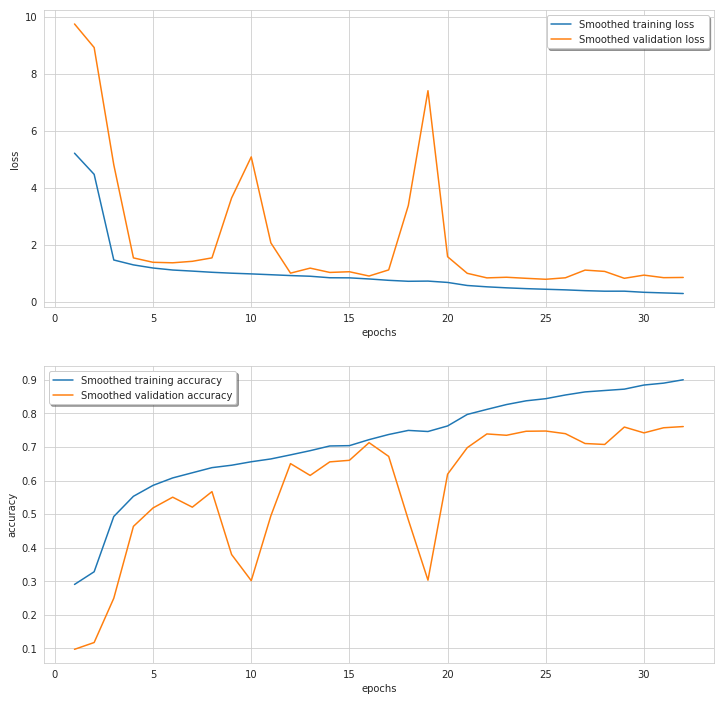

In [18]:
sns.set_style('whitegrid')
plot_smoothed_learning_curves(history)

In [19]:
#Load the best weights:
model.load_weights('best_weight.h5')

In [20]:
def plot_confusion_matrix(model, X_test, y_test):
    # Predict the values from the validation dataset
    y_pred = model.predict(X_test)
    # Because Y_pred is an array of probabilities, we have to convert it to one hot vectors 
    y_pred = np.argmax(y_pred, axis=1)
    #Compute and print the accuracy scores:
    print('accuracy score:', accuracy_score(y_test, y_pred))
    # compute the confusion matrix 
    # By definition a confusion matrix C is such that C_i,j is equal to the number of observations known to be in group i but predicted to be in group j.
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, index = range(10), columns = range(10))
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, cmap="Reds", annot=True, fmt='.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

accuracy score: 0.7415


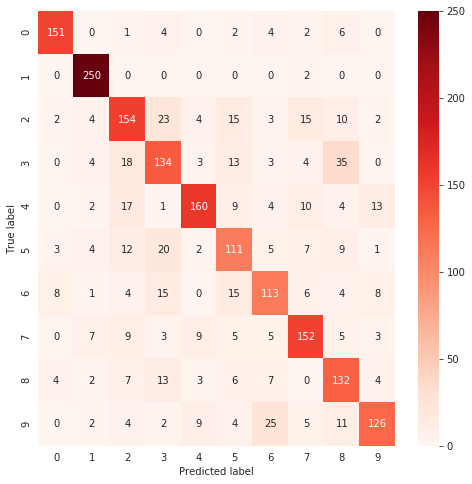

In [21]:
plot_confusion_matrix(model, X_test_rgb, y_test)